# Symmetric Key Encryption

Symmetric keys 演算法可分為: stream and block ciphers. 

- Stream ciphers 作用在data stream上, i.e. 一次1 bit 或 1 byte
- Block ciphers 作用在 blocks of data, 例如一次 16 bytes 

## Block Cipher

### AES
最廣為使用的 symmetric cipher 和 standard 是 the AES block cipher, 見 [FIPS PUB 197](http://csrc.nist.gov/publications/fips/fips197) 

建議可先看[這個](http://www.formaestudio.com/rijndaelinspector/archivos/Rijndael_Animation_v4_eng.swf) 動畫來複習AES!

### Padding

第一步我們先進行放寬第一章所說的byte長度的問題

> AES 為 Rijndael cipher的一部分. AES 以 128-bits (16 bytes) 固定為BLOCK SIZE; 而data必須經過padding來滿足block size的倍數.例如 "ABCDABCDABCDABCDABCDABCDABCDABCD" 這樣的訊息不用做padding。 但若訊息是 "ABCDABCDABCDABCDABCDABCDABCD" 則需要 4 byte的 padding

> 一個常見的padding scheme為將 0x80 當作第一個padding的byte，然後用 0x00 填滿剩下的padding。 例如前述例子會變成:"ABCDABCDABCDABCDABCDABCDABCD\x80\x00\x00\x00"

我們先定義一個padding函式

In [1]:
def pad_data(data):
    """pad_data pads out the data to an AES block length."""
    # return data if no padding is required
    if len(data) % 16 == 0:
        return data
    # subtract one byte that should be the 0x80
    # if 0 bytes of padding are required, it means only
    # a single \x80 is required.
    padding_required = 15 - (len(data) % 16)

    data = '%s\x80' % data
    data = '%s%s' % (data, '\x00' * padding_required)
    return data

def unpad_data(data):
    """unpad_data removes padding from the data."""
    if not data:
        return data

    data = data.rstrip('\x00')
    if data[-1] == '\x80':
        return data[:-1]
    else:
        return data

### Cipher mode
#### CBC
實務上用block cipher加密不會只加密一個block，所以我們必須先選mode. 常見的mode 包含 cipher block chaining or **CBC mode** or counter **CTR mode** (See Cryptography Engineering by Bruce Schneier). 

還有其他像**cipher feedback (CFB)**, **output feedback (OFB)** 及 **electronic codebook (ECB)**. CBC mode 是被廣泛使用的一種mode，我們會以他為主來探討。進一步來說 Cipher block chaining 會去 XORing 前一個 ciphertext block 和目前的 block.而一開始的bootstrap機制是用 **initialisation vector (IV)**來達成. 這需要一連串的randomly-generated bytes,並且要夠random無法反推!!

> 加解密最重要的部分之一是正確的產生 random data.我們會採用 PyCrypto library’s 中的 _Crypto.Random.OSRNG module_. 記住當我們有更多的 entropy sources (例如 network traffic 和 disk activity), 系統就能更快速的產生 cryptographically-secure random data. 下面我們寫一個適用於linux系統產生 initialisation vector 的function. 注意 gmp library 可以更新到  5.0 (timing attack resistant) or 6.0 (side channel silence mode) 來對抗 physical attacks.

![](https://i.imgur.com/dF9LU1z.png)


#### Randome number

In [4]:
import Crypto.Random.OSRNG.posix as RNG
import Crypto.Cipher.AES as AES 
def generate_nonce():
    """Generate a random number used once."""
    return RNG.new().read(AES.block_size)

In [5]:
nonce =  generate_nonce()
nonce, type(nonce)

('o\xdaql\x8d\xaa\x18\x9c\xa15\x80\xb0\xc5\xf0\xbcM', str)

> 注意 python 內建的 random module 為MT19937 是完全可預測的. 並不適合拿來寫 cryptographic code

### Key generation

Symmetric ciphers 的名稱便是雙方擁有一樣的金鑰. AES 有三種key size: **128-bit, 192-bit, and 256-bit, 或計做 16-byte, 24-byte, and 32-byte key sizes**. 這邊我們產生隨機的32 byte並記住他~~

In [6]:
KEY_SIZE = 32
def generate_key():
     return RNG.new().read(KEY_SIZE)

In [7]:
key =  generate_key()
key, type(key)

('\xad\xfd\x89\x17\x98w\x19\xc7-\x8c.\xa1\'\xbf\xa9{\x94`\xcb\xa1\xc9"\xd3T%\x94\xd7\xb8\xf6D\x7f\xdf',
 str)

### Encryption/Decryption

我們可以用這把key來加解密資料。加密的話我們需要 initialisation vector (i.e. a nonce), key, 和 data(plaintext). 然而, **IV isn’t a secret**. 當我們加密時IV會 prepend 在 encrypted data and make 前. 所以我們必須要對每一個新的plaintext產生新的random IV 

In [8]:
def encrypt(data, key):
     """
     Encrypt data using AES in CBC mode. The IV is prepended to the
     ciphertext.
     """
     data = pad_data(data)
     ivec = generate_nonce()
     aes = AES.new(key, AES.MODE_CBC, ivec)
     ctxt = aes.encrypt(data)
     return ivec + ctxt # 16 byte IV + 16 byte 
 
 
def decrypt(ciphertext, key):
     """
     Decrypt a ciphertext encrypted with AES in CBC mode; assumes the IV
     has been prepended to the ciphertext.
     """
     if len(ciphertext) <= AES.block_size:
         raise Exception("Invalid ciphertext.")
     ivec = ciphertext[:AES.block_size]
     ciphertext = ciphertext[AES.block_size:]
     aes = AES.new(key, AES.MODE_CBC, ivec)
     data = aes.decrypt(ciphertext)
     return unpad_data(data)

In [9]:
key = generate_key()
plaintext = 'Martinet!'

print len(key), len(plaintext)
 
ciphertext = encrypt(plaintext, key)

print len(ciphertext), ciphertext, ciphertext.encode('hex') # 印出好看用!

plaintext = decrypt(ciphertext, key)
 
# Resulting plaintext
print plaintext

32 9
32 �������r��_�y�`W.�p��Q�	� al b7f2c8e19a1381c2ce72ccc35ffb798960572ec970138eac51a1099d20616c01
Martinet!


### Authenticate

不過要注意的是 AES 僅確保了 confidentiality. 我們常常還需要 **integrity and authenticity** 等服務

或許直覺會想到MD5或SHA，不過他們缺點是digest可以被隨意改變(且MD5已不再安全)。

這邊我們需要的是, 將 hash function 加入 key 來產生 digest。也就是我們需要 HMAC (which is a general framework)。另外，實務上我們不會用跟加密一樣的key。 我們需要的是 **new, freshly generated key**。

這個framework中，我們需要加入SHA函數.因為我們使用 AES-256, 所以必須使用 SHA-512 (Remember the birthday attack~). 我們的 message tags 是經由 HMAC-SHA-512 來計算. 將產生 64-byte digest. 我們以下定義一些constant~

In [10]:
__AES_KEYLEN = 32
__TAG_KEYLEN = 64
__TAG_LEN = __TAG_KEYLEN
#KEYSIZE = __AES_KEYLEN + __TAG_KEYLEN

In [11]:
import Crypto.Hash.HMAC as HMAC
import Crypto.Hash.SHA512 as SHA512
 
def new_tag(ciphertext, key):
     """Compute a new message tag using HMAC-SHA-512."""
     return HMAC.new(key, msg=ciphertext, digestmod=SHA512).digest()

這是我們修改後的加密函式!

In [12]:
def encrypt(data, key):
    """
    Encrypt data using AES in CBC mode. The IV is prepended to the
    ciphertext.
    """
    data = pad_data(data)
    ivec = generate_nonce()
    aes = AES.new(key[:__AES_KEYLEN], AES.MODE_CBC, ivec)
    ctxt = aes.encrypt(data)
    tag = new_tag(ivec + ctxt, key[__AES_KEYLEN:]) 
    return ivec + ctxt + tag

#### Timing attack

解密做的事是確認我們的 message tag 必須正確。 然而一般來說直接使用 == 會循序進行比對每一個byte並在第一次不對的時候就跳出(純速度考量)。 這樣的比對會遭遇 **timing attack**。在python中我們可以用 streql package (i.e. pip install streql) 來進行 constant-time 的比對

In [13]:
import streql
def verify_tag(ciphertext, key):
    """Verify the tag on a ciphertext."""
    tag_start = len(ciphertext) - __TAG_LEN
    data = ciphertext[:tag_start]
    tag = ciphertext[tag_start:]
    actual_tag = new_tag(data, key)
    return streql.equals(actual_tag, tag)

In [14]:
def decrypt(ciphertext, key):
     """
     Decrypt a ciphertext encrypted with AES in CBC mode; assumes the IV
     has been prepended to the ciphertext.
     """
     if len(ciphertext) <= AES.block_size:
         return None, False
     tag_start = len(ciphertext) - __TAG_LEN
     ivec = ciphertext[:AES.block_size]
     data = ciphertext[AES.block_size:tag_start]
     if not verify_tag(ciphertext, key[__AES_KEYLEN:]):
         return None, False
     aes = AES.new(key[:__AES_KEYLEN], AES.MODE_CBC, ivec)
     data = aes.decrypt(data)
     return unpad_data(data), True

In [15]:
key = generate_key()
plaintext = 'Martinet!'

print len(key), len(plaintext)
 
ciphertext = encrypt(plaintext, key)

print len(ciphertext), ciphertext, ciphertext.encode('hex') # 印出好看用!

32 9
`Hw{��GI2��fe"L+�ac��2T()����Wrq�>{����"��ke	e 052d6450e594d91583676af3ba5c8a44bcc93ad66e18399bd2223cda3dade217bce8530c0b37589e07a4590d6048777b06b0861f47491d3282da666501224c2bba6163abbb32542829bcb28a12b3577271ed3e7b9181811fe622f98a6b650965


In [16]:
plaintext = decrypt(ciphertext, key)
 
# Resulting plaintext
print plaintext

('Martinet!', True)


> 另外還有其他值得注意的模式像是 CTR, GCM, XTS(Cipher Stealing的技巧，常用於disk加密)


### Key Derivation Function

前述我們是使用隨機產生的金鑰，在現實生活中我比較常見們比較常見的做法是讓使用者輸入password然後將其經過處理轉成金鑰。因此我們會需要一個 key derivation algorithm，像是PBKDF2。 這類function通常還會需要 salt來增加安全度。因此 PBKDf2 有三個輸入；passphrase, salt, 和迴圈跑的次數. 目前普遍認為安全的 iterations 為 16384。

> Salt是什麼? Salt 是隨機產生的數，他可以確保KDF在相同 passphrase 下有不同結果。 通常來說他的長度要求為 16 bytes (128-bits).

接下來我們實做兩個函數： generate a random salt 和 generate a secret key from PBKDF2:

In [19]:
import pbkdf2 
KEYSIZE = 32
def generate_salt(salt_len):  
    """Generate a salt for use with PBKDF2."""
    return RNG.new().read(salt_len)

def password_key(passphrase, salt=None):
    """Generate a key from a passphrase. Returns the tuple (salt, key)."""
    if salt is None:
        salt = generate_salt(16)
    passkey = pbkdf2.PBKDF2(passphrase, salt, iterations=16384).read(KEYSIZE)
    return salt, passkey

In [20]:
keyin = 'star'
salt, key = password_key(keyin)
print (salt, key)

('%\xa5;4\xfc\t\xb3\x1e\x1d\x13e=\x9dfZ\xb0', '0\x7f\xcc\xbdP\x99\xf2\x12\xc4\xe5\x11\xb7\x90\xcb\xf1\xbeG\x8f\xa8\x8a\xf8\xd2\x1bx\xe3,\xa3\xce\xa4\x0cJ\xa4')


注意salt也是公開的，他也必須存下來來還原key，可以用同樣的方法例如頭 len(salt) bytes 附加在 ciphertext前面。

### ASCII-Armouring

有些人會習慣用base64 encode來處理， 而不是用binary data。接下來試一個完整的範例。

In [21]:
keyin = 'star'
plaintext = 'AG is god'
salt, key = password_key(keyin)
ciphertext = encrypt(plaintext, key)

In [22]:
print decrypt(ciphertext, key)

('AG is god', True)


### Yet another AES example

下面我們舉加密圖片來看看各種Block cipher mode的範例。

In [23]:
import sys
import os
import math
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from Crypto.Cipher import AES

In [24]:
IV_SIZE = 16
BLOCK_SIZE = 16

In [25]:
def fn_entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [26]:
def encrypt_image(cipher_mode):
    """Encrypt an image file and write out the results as a JPEG."""

    input_image = Image.open(os.getcwd() + '/yuwen.jpg')
    print input_image
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.imshow(input_image)

    # Key must be one of 16/24/32 bytes in length.
    key = "0123456789ABCDEF"
    if cipher_mode == 'ECB':
        mode = AES.MODE_ECB
    elif cipher_mode == 'CBC':
        mode = AES.MODE_CBC
    elif cipher_mode == 'CFB':
        mode = AES.MODE_CFB
    elif cipher_mode == 'OFB':
        mode = AES.MODE_OFB
    iv = os.urandom(IV_SIZE)

    aes = AES.new(key, mode, iv)

    image_string = input_image.tobytes()
    # The input string must be padded to the input block size.
    image_padding_length = BLOCK_SIZE - len(image_string) % BLOCK_SIZE
    image_string += image_padding_length * "~"

    # generate the encrypted image string
    encrypted = aes.encrypt(image_string)

    # create an image from the encrypted string
    encrypted_img = Image.frombuffer("RGB", input_image.size, encrypted, 'raw', "RGB", 0, 1)
    
    plt.subplot(122)
    plt.imshow(encrypted_img)
    plt.show()
    
    # create and save the output image
    # encrypted_img.save(output_filename, 'PNG')

    print("Encrypted using AES in " + cipher_mode + " mode!")
    print 'Entropy on original:  ', fn_entropy(image_string)
    print 'Entropy on encryption: ', fn_entropy(encrypted_img.tobytes())

In [27]:
def encrypt_text(text,cipher_mode):
    
    # Key must be one of 16/24/32 bytes in length.
    key = "0123456789ABCDEF"
    if cipher_mode == 'ECB':
        mode = AES.MODE_ECB
    elif cipher_mode == 'CBC':
        mode = AES.MODE_CBC
    elif cipher_mode == 'CFB':
        mode = AES.MODE_CFB
    elif cipher_mode == 'OFB':
        mode = AES.MODE_OFB
    iv = os.urandom(IV_SIZE)

    aes = AES.new(key, mode, iv)
    
    # Padding
    # The input string must be padded to the input block size.
    text_padding_length = BLOCK_SIZE - len(text) % BLOCK_SIZE
    text += text_padding_length * "~"
    text += text
    
    text_enc = aes.encrypt(text)
    
    print("Encrypted using AES in " + cipher_mode + " mode!")
    print 'Input text:     ', text
    print 'Encrypted text: ', text_enc.encode('hex')
    ####

In [28]:
encrypt_text('Hello World','ECB')

Encrypted using AES in ECB mode!
Input text:      Hello World~~~~~Hello World~~~~~
Encrypted text:  bd3a2268346f62d2af6f0a4349e3e5abbd3a2268346f62d2af6f0a4349e3e5ab


In [29]:
encrypt_text('Hello World','CBC')

Encrypted using AES in CBC mode!
Input text:      Hello World~~~~~Hello World~~~~~
Encrypted text:  455ab37dedc28a3b25ee27f527e3e692506392d0dd76a5b561f8c1277d6473fd


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x960 at 0x7FE38F31A200>


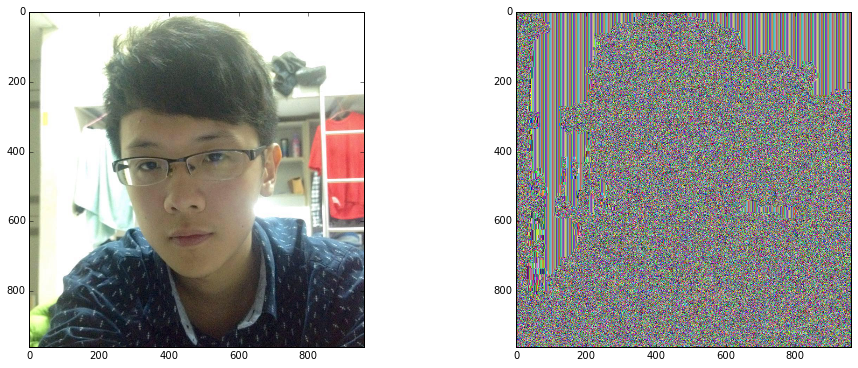

Encrypted using AES in ECB mode!
Entropy on original:   7.00650054307
Entropy on encryption:  7.80861248594


In [30]:
encrypt_image('ECB')

上圖 (Mon god) 有加密嗎?

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x960 at 0x7FE38F3D4BD8>


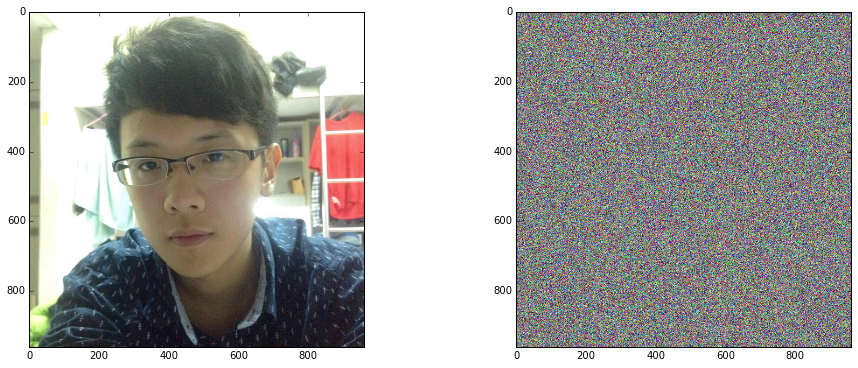

Encrypted using AES in CBC mode!
Entropy on original:   7.00650054307
Entropy on encryption:  7.99993663517


In [31]:
encrypt_image('CBC')

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x960 at 0x7FE38F33FE18>


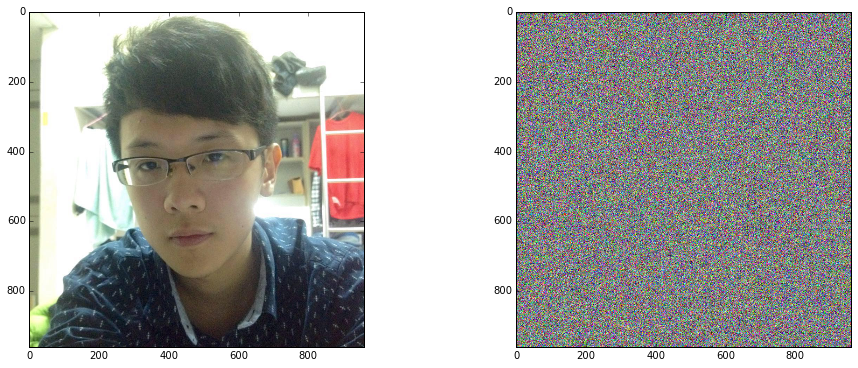

Encrypted using AES in CFB mode!
Entropy on original:   7.00650054307
Entropy on encryption:  7.99993578282


In [32]:
encrypt_image('CFB')

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x960 at 0x7FE38F2F44D0>


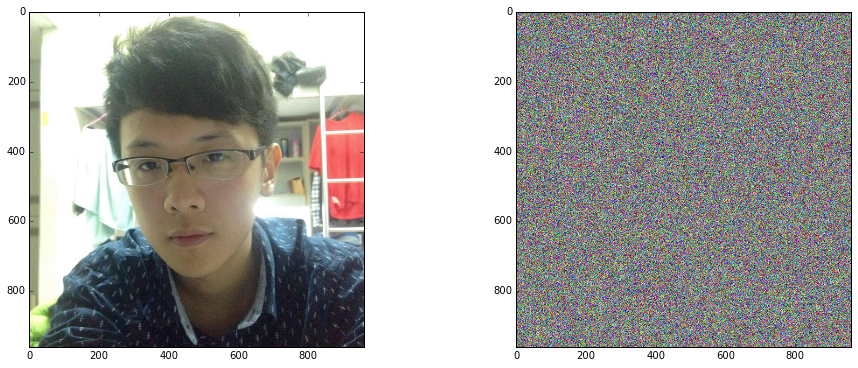

Encrypted using AES in OFB mode!
Entropy on original:   7.00650054307
Entropy on encryption:  7.99992302409


In [33]:
encrypt_image('OFB')

### Cryptography
我們用 _cryptography toolkit_來看看一個新的mode - GCM (包含加解密和認證)

In [34]:
import os
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.ciphers import (
    Cipher, algorithms, modes
)

def encrypt(key, plaintext, associated_data):
    # Generate a random 96-bit IV.
    iv = os.urandom(12)

    # Construct an AES-GCM Cipher object with the given key and a
    # randomly generated IV.
    encryptor = Cipher(
        algorithms.AES(key),
        modes.GCM(iv),
        backend=default_backend()
    ).encryptor()

    # associated_data will be authenticated but not encrypted,
    # it must also be passed in on decryption.
    encryptor.authenticate_additional_data(associated_data)

    # Encrypt the plaintext and get the associated ciphertext.
    # GCM does not require padding.
    ciphertext = encryptor.update(plaintext) + encryptor.finalize()

    return (iv, ciphertext, encryptor.tag)

def decrypt(key, associated_data, iv, ciphertext, tag):
    # Construct a Cipher object, with the key, iv, and additionally the
    # GCM tag used for authenticating the message.
    decryptor = Cipher(
        algorithms.AES(key),
        modes.GCM(iv, tag),
        backend=default_backend()
    ).decryptor()

    # We put associated_data back in or the tag will fail to verify
    # when we finalize the decryptor.
    decryptor.authenticate_additional_data(associated_data)

    # Decryption gets us the authenticated plaintext.
    # If the tag does not match an InvalidTag exception will be raised.
    return decryptor.update(ciphertext) + decryptor.finalize()

In [35]:
iv, ciphertext, tag = encrypt(key,b"a secret message!",b"authenticated but not encrypted payload")

print(decrypt(key,b"authenticated but not encrypted payload",iv,ciphertext,tag))

a secret message!


### The Recipe Layer

上述要實現一個安全的演算法所要考量的事情很多，因此有些library便會統一提供單一介面能夠更加安全的使用，當然缺點就是失去一些選擇的彈性(演算法，padding方式、安全速度tradeoff等)

Fernet 建構在一系列 standard cryptographic primitives上 包含:

- AES in CBC mode, 128-bit key; 用 PKCS7 padding.
- HMAC 用 SHA256 來認證.
- Initialization vectors 用 os.urandom() (而非語言內建)

> 大多專家會建議使用 operating system 的 random number generator，在python可透過 os.urandom()存取。在UNIX系統中他會拿 /dev/urandom 在windows會用 CryptGenRandom


因此我們要注意的只剩key的產生: 	
```
key (bytes) – A URL-safe base64-encoded 32-byte key. This must be kept secret. Anyone with this key is able to create and read messages.
```

In [36]:
import base64
import os
from cryptography.fernet import Fernet
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
password = b"password"
salt = os.urandom(16)
kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=32,
    salt=salt,
    iterations=100000,
    backend=default_backend()
)
key = base64.urlsafe_b64encode(kdf.derive(password))
f = Fernet(key)
token = f.encrypt(b"Secret message!")
token

'gAAAAABXjyC94ETjdCt_ObQv83S2I1j8-AZURE83Yvddns1xyCDQZmL56uzNlOTDLNkffehnuAEQyu3B8tjnG5TRs4p4ftO9ZQ=='

In [37]:
f.decrypt(token)

'Secret message!'

## Stream Cipher

我們可以使用pynacl來使用Salsa20這類由eS

In [38]:
import nacl
nacl

<module 'nacl' from '/usr/lib/python2.7/dist-packages/nacl/__init__.pyc'>

In [39]:
import nacl.secret
import nacl.utils

# This must be kept secret, this is the combination to your safe
key = nacl.utils.random(nacl.secret.SecretBox.KEY_SIZE)

# This is your safe, you can use it to encrypt or decrypt messages
box = nacl.secret.SecretBox(key)

# This is our message to send, it must be a bytestring as SecretBox will
#   treat is as just a binary blob of data.
message = b"The president will be exiting through the lower levels"

# This is a nonce, it *MUST* only be used once, but it is not considered
#   secret and can be transmitted or stored alongside the ciphertext. A
#   good source of nonce is just 24 random bytes.
nonce = nacl.utils.random(nacl.secret.SecretBox.NONCE_SIZE)

# Encrypt our message, it will be exactly 40 bytes longer than the original
#   message as it stores authentication information and nonce alongside it.
encrypted = box.encrypt(message, nonce)

# Decrypt our message, an exception will be raised if the encryption was
#   tampered with or there was otherwise an error.
plaintext = box.decrypt(encrypted)

In [41]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pycrypto, cryptography, nacl, version_information

Software,Version
Python,2.7.10 64bit [GCC 5.2.1 20151010]
IPython,5.0.0
OS,Linux 4.2.0 30 generic x86_64 with Ubuntu 15.10 wily
numpy,1.8.2
scipy,0.14.1
matplotlib,1.4.2
pycrypto,2.6.1
cryptography,1.0.1
nacl,0.3.0
version_information,1.0.3
